# Calcul de la consommation globale

On commence par charger les données, on les affiche, on les trie et on fait une première synthèse des consommation par moteur et par vol.

L'idées est de construire une table résumant les données de chaque vol et la consommation correspondate de chaque moteur.

In [39]:
import os
from glob import glob
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import tabata as tbt
from tabata import Opset
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import shapiro
# from scipy import stats
import seaborn as sns
%matplotlib inline
from utils import detect_phase, get_consumption, plot_residuals, RelativeIqr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [40]:
%reload_ext autoreload
%autoreload 2

# 1. Récupération et affichage des données.

In [4]:
datadir = "../../data/"
datafiles = glob(os.path.join(datadir,'*.h5'))
datafiles

['../../data\\Aircraft_01.h5',
 '../../data\\Aircraft_02.h5',
 '../../data\\Aircraft_03.h5']

### On affiche les données de manière à mieux comprendre comment définir les phases de vol. Pour simplifier les accès j'utilise l'Opset de tabata.

In [35]:
sorting = lambda name: int(name[8:])
ds1 = Opset(datafiles[0], sortkey=sorting)
# ds1.plotc()

In [36]:
ds2 = Opset(datafiles[1], sortkey=sorting)
ds2.storename

'../../data\\Aircraft_02.h5'

In [37]:
ds3 = Opset(datafiles[2], sortkey=sorting)
ds3.storename

'../../data\\Aircraft_03.h5'

### Un affichage interactif avec des variables en parallèle de l'altitude.

In [41]:
from ipywidgets import interact, widgets

def mydoubleplot(varname, record):
    df = ds1[record]
    tbt.doubleplot(df[varname], df["N2_1 [% rpm]"], title="Vol {}".format(record))

interact(mydoubleplot, varname=ds1.df.columns, record=widgets.IntSlider(0,0,len(ds1)-1,1)) ; #range(len(ds))) 

interactive(children=(Dropdown(description='varname', options=('ALT [ft]', 'EGT_1 [deg C]', 'EGT_2 [deg C]', '…

# 2. Construction des datasets

## Dataset initial: duration ~ conso

In [50]:
# LB2KG = 0.453592  # kg/lb 
# KDENS = 0.73      # kg/l
# L = []
# for file in datafiles:
#     ac = 'AC'+file[-5:-3]
#     ds = Opset(file,sortkey=sorting) # Ne pas oublier de trier les enregistrements.
#     for i,df in enumerate(ds):
#         if len(df.columns)>0 and "ALT [ft]" in df.columns:
#             alt = df["ALT [ft]"]
#             Alt_max = max(alt)
#             if Alt_max > 20000:
#                 mc = df["M [Mach]"]
#                 # Il faudra peut-être séparer la montée et la descente de la croisière.
#                 # df1 = df[mc>0.1]
#                 df1 = df.copy()
#                 Leg = len(df1)/3600.0 # en h
#                 Q1 = df1["Q_1 [lb/h]"].sum()/3600.0 # en lb
#                 Q2 = df1["Q_2 [lb/h]"].sum()/3600.0
#                 M1 = Q1*LB2KG # en kg
#                 M2 = Q2*LB2KG

#                 C1 = M1/KDENS # en l
#                 C2 = M2/KDENS
#                 L += [[ac, 'Left', i, Leg, C1]]
#                 L += [[ac, 'Right', i, Leg, C2]]
# dft = pd.DataFrame(L,columns = ['AC', 'ENG', 'Flight', 'Leg_flight_H', 'Volume_L'])

In [12]:
# stockage du dataframe dans un .csv

# dft.to_csv("aircraft_data_conso.csv", index=False)

In [6]:
df_conso = pd.read_csv('aircraft_data_conso.csv')

In [7]:
df_conso.head()

,AC,ENG,Flight,Leg_flight_H,Volume_L
0,AC01,Left,0,2.063611,2701.955527
1,AC01,Right,0,2.063611,2719.403852
2,AC01,Left,1,2.071944,2762.223811
3,AC01,Right,1,2.071944,2773.378954
4,AC01,Left,2,1.956111,2507.737284


### On sépare les données en données de d'entraînement (aricraft 1 et aircraft 2) et en données de test (aircraft 3)

In [8]:
df_conso_train = df_conso[df_conso["AC"].isin(("AC01", "AC02"))]
df_conso_test = df_conso[df_conso["AC"]=="AC03"]
df_conso_test = df_conso_test.set_index(pd.Index(range(len(df_conso_test))))   #reindexation du dataframe

print(df_conso_train.shape)
print(df_conso_test.shape)

(3994, 5)
(2000, 5)


## Dataset par phases

In [9]:
# all_phases = ['taxi1','climb','cruise','descend','taxi2']
# dfc1_all = [get_consumption(ds1, phase=p) for p in all_phases]
# dfc2_all = [get_consumption(ds2, phase=p) for p in all_phases]
# dfc3_all = [get_consumption(ds3, phase=p) for p in all_phases]

In [10]:
# df_fin = pd.concat([d for d in dfc1_all] + [d for d in dfc2_all] + [d for d in dfc3_all], axis=0, ignore_index=True)
# df_fin.dropna(inplace=True)
# df_fin = df_fin[df_fin['Volume_L']>0]
# df_fin

In [11]:
# df_fin.to_csv("aircraft_data_phase.csv", index=False)
df_fin = pd.read_csv("aircraft_data_phase.csv")

In [12]:
df_fin.head()

,AC,ENG,Flight,Phase,Leg_flight_H,Leg_phase_H,Alt_max_Ft,Alt_slope,Avg_egt,TAT_max,TAT_min,T_oil_range,M_max,TLA,NAIV,Volume_L,Weight_Kg
0,AC01,Left,0,taxi1,2.063611,0.228611,39439.264501,0.039437,862.015543,40.814093,-22.163944,59.739683,0.640898,27,0.0,75.893561,116.630099
1,AC01,Right,0,taxi1,2.063611,0.228611,39439.264501,0.039437,862.015543,40.814093,-22.163944,62.940023,0.640898,31,0.0,83.873698,116.630099
2,AC01,Left,1,taxi1,2.071944,0.176667,39457.811063,0.029161,816.434746,40.543801,-20.271900,53.339003,0.649114,26,0.0,52.231316,82.704420
3,AC01,Right,1,taxi1,2.071944,0.176667,39457.811063,0.029161,816.434746,40.543801,-20.271900,54.939173,0.649114,23,0.0,61.062409,82.704420
4,AC01,Left,2,taxi1,1.956111,0.264444,40825.620025,0.029223,1022.816007,32.164749,-29.191536,68.807313,0.624464,15,0.0,126.556068,191.562454


In [13]:
df_train = df_fin[df_fin["AC"].isin(("AC01", "AC02"))]
df_test = df_fin[df_fin["AC"]=="AC03"]
df_test = df_test.set_index(pd.Index(range(len(df_test))))
print(df_train.shape)
print(df_test.shape)

(19924, 17)
(9990, 17)


# 3. Mise en place du modèle global

### Affichage de la consommation en fonction de la durée du vol.

On présente une relation entre durée du vol et consommation.
La variance résiduelle peut eut-être être encore réduite en travaillant sur la montée et la descente séparemment de la croisière.

In [ ]:
fig = px.scatter(df_conso, x="Leg_flight_H", y="Volume_L", color="AC", symbol="ENG", 
           hover_data=dict(AC=True, ENG=True, Flight=True, Leg_flight_H=False, Volume_L=False), 
           opacity=0.4,
           title="Consommation en fonction de la durée de vol",
           labels={"Volume_L" : "Consommation (litres)", "Leg_flight_H" : "Durée du vol (heures)"})
fig.update_traces(marker=dict(size=12))

In [ ]:
# On se focalise sur une durée particulière.
fig = px.scatter(df_conso, x="Leg_flight_H", y="Volume_L", color="AC", symbol="ENG", 
           hover_data=dict(AC=True, ENG=True, Flight=True, Leg_flight_H=False, Volume_L=False), 
           opacity=0.4,
           title="Consommation en fonction de la durée de vol",
           labels={"Volume_L" : "Consommation (litres)", "Leg_flight_H" : "Durée du vol (heures)"})
fig.update_traces(marker=dict(size=12))
fig.update_layout(xaxis_range=[1.96,2.1], yaxis_range=[2400, 3500])

Notons que sur cette image nous observons un écart de plus de 1000 litres de carburant pour une durée d'environ 2h de vol.

In [15]:
# modèle 1 en fonction de la durée du vol uniquement 

model_raw = smf.ols("Volume_L ~ Leg_flight_H", data=df_conso_train)
res = model_raw.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Volume_L   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                 5.716e+04
Date:                Fri, 01 Mar 2024   Prob (F-statistic):               0.00
Time:                        04:39:00   Log-Likelihood:                -26831.
No. Observations:                3994   AIC:                         5.367e+04
Df Residuals:                    3992   BIC:                         5.368e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -71.6177     11.711     -6.116      0.000     -94.577     -48.658
Leg_flight_H  1287.8806      5.387    239.091      0.000    1277.320    1298.441
==============================================================================
Omnibus:                     2726.705   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97347.359
Skew:                          -2.770   Prob(JB):                         0.00
Kurtosis:                      26.543   Cond. No.                         9.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
y = df_conso_test['Volume_L'].values
hy = res.predict(df_conso_test['Leg_flight_H']).values

df1 = df_conso_test.copy()
df1['Predictions'] = hy
df1.head()

,AC,ENG,Flight,Leg_flight_H,Volume_L,Predictions
0,AC03,Left,0,2.534444,3323.671951,3192.444183
1,AC03,Right,0,2.534444,3322.417203,3192.444183
2,AC03,Left,1,2.479167,3236.949272,3121.253004
3,AC03,Right,1,2.479167,3230.570845,3121.253004
4,AC03,Left,2,1.720000,2101.487565,2143.536958


In [175]:
# y = df_conso_train['Volume_L'].values
# hy = res.predict()
# iqr = RelativeIqr(y,hy,p=20)
# print(iqr.score())
# print(f"MAE = {mean_absolute_error(y,hy)}")
# iqr.plot()

# 4. Mise en place du modèle multiphase

In [17]:
def shapiro_test(res):
    residus = res.resid
    test = shapiro(residus)
    print(f"Test statistic:      {test.statistic}\n")
    print(f"P-value:                   {test.pvalue}\n")
    if test.pvalue < 0.05:
        print("Residuals are not Gaussian.\n\n\n\n")
    else:
        print("Residuals are Gaussian.\n\n\n\n")

def plot_predictions(dataframe, results, phase):
    """
    results : a trained model object from statsmodels
    """
    df = dataframe.copy()
    df["Prediction"] = results.predict()
    fig = px.scatter(df, x="Prediction", y="Volume_L", color="AC", symbol="ENG", 
           hover_data=dict(AC=True, ENG=True, Flight=True), 
           opacity=0.4,
           title=phase.upper()+" Consumption ",
           labels={"Volume_L" : "Consumption (liters)", "Prediction" : "Estimated consumption"})
    fig.update_traces(marker=dict(size=12))
    fig.show()

In [18]:
features = ['Leg_flight_H', 'Leg_phase_H', 'Alt_max_Ft', 'Alt_slope', 'Avg_egt', 'TAT_max', 'TAT_min', 'T_oil_range', 'M_max', 'TLA', 'NAIV']

In [19]:
class ModelConsoByPhase:
    """
    A class for phase-by-phase learning from aircraft data


        Parameters : 
        ----------
        
        acs : list,
            one aircraft flights or a list of aircraft flights

        phases : list,
            list of phases between taxi1, climb, cruise, descend, taxi2 (`'all'` for all phases)

        altitude_threshold : float, default=0.95,
            threshold for extracting cruising phase 

            
        Methods :
        ---------
    
        construct_dataset() : 
            get the global dataset if a list of aircraft is given
        add_model() :
            create a model for each phase
        fit() :
            model learning
        update_features() :
            removing non-significant features one after the other
        predict(new_data) :
            estimated consumption on the `new_data`
        score(df, c, p, enveloppe) :
            estimation of mean relative error on predictions
        model_summary(phase, summary, analyse_residus, prediction_plot):
            summary of the trained model for the specified phase

            
        Attributes:
        -----------

        final_dataset : DataFrame,
            global dataset if a list of aircraft is given
        variables : dict,
            significant features for each phase
        models : dict,
            model for each phase
        results : dict,
            trained model for each phase
        predictions : dict, 
            for each phase, contains a DataFrame with all features and predictions
        MAE : float,
            for each phase, mean absolute error on trained data predictions 
    """
    
    def __init__(self, acs, phases = None, altitude_threshold = 0.95):
        if isinstance(phases,str):
            if phases=='all':
                phases = ['taxi1','climb','cruise','descend','taxi2']
            else:
                phases = [phases]
                
        assert len(phases)>=1, "At least one phase should be given"

        self.aircraft = acs
        if len(self.aircraft)>1: self.aircraft_names = [ac.storename[-14:-3] for ac in acs]
        self.phases = phases
        self.threshold = altitude_threshold
        self.final_dataset = self.construct_dataset()
        self.variables = {p:features  for p in self.phases} 
        self.models = self.add_models(self.variables)
        self.results = {}
        self.predictions = {}
        self.MAE = {}
        


    def construct_dataset(self):
        """
        Construct the global dataset if a list of aircraft is given
        """

        if len(self.aircraft) == 1:
            return self.aircraft[0]
        else:
            all_ = []
            for ac in self.aircraft:
                for p in self.phases:
                    all_.append(get_consumption(ac, phase=p, threshold=self.threshold))
            return pd.concat([d for d in all_], axis=0, ignore_index=True).dropna()

    def add_models(self, var):
        """
        Create a model for each phase
        """
        var = self.variables
        df = self.final_dataset
        dfs = { p:df[df['Phase'] == p] for p in self.phases }
        models = {p: smf.ols(f"Volume_L ~ {'+'.join(var[p])}", data=dfs[p])
                   for p in self.phases}
        return models
    
    def fit(self):
        """
        Model learning
        """
        for p, mod in self.models.items():
            self.results[p] = mod.fit()

    def update_features(self):
        """
        Removing non-significant features one after the other
        """
        results = self.results
        for p in results:
            pval_series_sort = results[p].pvalues.iloc[1:].sort_values()
            new_var = list(pval_series_sort[pval_series_sort<0.05].index)
            new_var += list(pval_series_sort[pval_series_sort>=0.05].index)[:-1]
            self.variables[p] = new_var

        self.models = self.add_models(self.variables)
        self.fit()

    def predict(self, new_data):
        """
        Estimated consumption on the `new_data`
        """
        for p in self.phases:
            X = new_data[new_data['Phase']==p]
            y_true = X['Volume_L'].values
            C = X.copy()
            X = X[self.variables[p]]
            C['Volume_L'] = y_true
            pred = self.results[p].predict(X).values
            C['Predictions'] = pred

            self.MAE[p] = mean_absolute_error(y_true, pred)
            self.predictions[p] = C.copy()
        return self.predictions

    
    def score(self, df, c=95, p=5, enveloppe=True):
        """
        Estimation of mean relative error on predictions

        df : dataframe with targets and predictions
        c : precision of the confidence interval for the calculated relative deviation (default 95%)
        p : relative precision for envelope calculation (default 5%).
        """
        y = df['Volume_L'].values
        hy = df['Predictions'].values
        res = RelativeIqr(y, hy, c, p=20)
        res.plot()
        if enveloppe:
            return res.score()
        else:
            return res.score(False)

        
    def model_summary(self, phase, summary=True, analyse_resid=False, prediction_plot=False):
        """
        Summary of the trained model for the specified phase

        phase : str, flight phase
        summary : bool, if `True` display summary resulting from statsmodels
        analyse_resid : bool, if `True` display an analysis of residuals
        prediction_plot: bool, if `True` plot the prediction on trained data
        """
        df = self.final_dataset[ self.final_dataset['Phase']==phase ]
        results = self.results[phase]
        if summary:
            return results.summary()
        if analyse_resid:
            shapiro_test(results)
            plot_residuals(results, title=phase.upper())
        if prediction_plot:
            plot_predictions(df, results, phase)
     

In [20]:
# model = ModelConsoByPhases(acs= [df_train], phases=['climb', 'cruise', 'descend'])
modelByPhase = ModelConsoByPhase(acs= [df_train], phases='all')

In [21]:
modelByPhase.fit()

In [25]:
modelByPhase.update_features()

In [42]:
# modelByPhase.model_summary('taxi1', summary=True, analyse_residus=False, prediction_plot=False)
modelByPhase.model_summary('climb', summary=True, analyse_resid=False, prediction_plot=False)
# modelByPhase.model_summary('cruise', summary=False, analyse_resid=False, prediction_plot=True)
# modelByPhase.model_summary('descend', summary=False, analyse_resid=True, prediction_plot=False)
# modelByPhase.model_summary('taxi2', summary=False, analyse_resid=False, prediction_plot=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Volume_L   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 5.342e+04
Date:                Fri, 01 Mar 2024   Prob (F-statistic):               0.00
Time:                        04:50:19   Log-Likelihood:                -16994.
No. Observations:                3984   AIC:                         3.401e+04
Df Residuals:                    3974   BIC:                         3.407e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -365.9631     16.299    -22.453      0.000    -397.918    -334.008
Leg_phase_H   1388.3154      4.385    316.613      0.000    1379.719    1396.912
Alt_slope       -5.9428      0.101    -58.861      0.000      -6.141      -5.745
Avg_egt          0.4806      0.009     52.690      0.000       0.463       0.499
TLA             -0.1758      0.012    -14.242      0.000      -0.200      -0.152
Alt_max_Ft       0.0029      0.000     14.217      0.000       0.003       0.003
M_max          232.7840     17.117     13.599      0.000     199.225     266.343
TAT_max         -0.5766      0.045    -12.769      0.000      -0.665      -0.488
Leg_flight_H     6.6069      0.595     11.098      0.000       5.440       7.774
TAT_min         -0.6402      0.072     -8.923      0.000      -0.781      -0.500
==============================================================================
Omnibus:                     1366.452   Durbin-Watson:                   1.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24483.525
Skew:                          -1.165   Prob(JB):                         0.00
Kurtosis:                      14.919   Cond. No.                     2.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
modelByPhase.MAE

{'taxi1': 11.029847681134763,
 'climb': 13.503856472523935,
 'cruise': 28.7482939755551,
 'descend': 17.48353033220594,
 'taxi2': 5.377735930583425}

In [28]:
ac03_pred = modelByPhase.predict(df_test)
ac03_pred['climb'].head()

,AC,ENG,Flight,Phase,Leg_flight_H,Leg_phase_H,Alt_max_Ft,Alt_slope,Avg_egt,TAT_max,TAT_min,T_oil_range,M_max,TLA,NAIV,Volume_L,Weight_Kg,Predictions
1998,AC03,Left,0,climb,2.534444,0.359167,42003.326724,30.889421,1527.673543,40.273509,-33.516209,20.268821,0.640898,63,0.0,965.296041,1408.748142,958.979584
1999,AC03,Right,0,climb,2.534444,0.359167,42003.326724,30.889421,1527.673543,40.273509,-33.516209,20.802211,0.640898,65,0.0,964.495934,1408.748142,958.627939
2000,AC03,Left,1,climb,2.479167,0.265278,40603.061279,40.035328,1561.108094,46.760517,-31.083580,18.668651,0.640898,44,0.0,791.141803,1154.058268,783.942251
2001,AC03,Right,1,climb,2.479167,0.265278,40603.061279,40.035328,1561.108094,46.760517,-31.083580,19.735431,0.640898,45,0.0,789.759935,1154.058268,783.766429
2002,AC03,Left,2,climb,1.720000,0.269444,41790.041259,40.926718,1571.678902,27.299492,-34.327085,21.335601,0.640898,30,0.0,805.857798,1172.744412,803.716654


### We sum up the consumption for each phase to obtain a prediction of total flight consumption on aircraft 3 

In [29]:
columns = [ 'AC', 'ENG', 'Flight', 'Phase', 'Leg_flight_H', 'Volume_L', 'Predictions' ]
dataframes = []
for p, df_ in ac03_pred.items():
    dataframes.append(df_[columns])

data = pd.concat(dataframes, axis=0, ignore_index=True)

dat = []
for f in data['Flight'].unique():
    df = data[data['Flight']==f]
    dat += [['AC03', f, 'Left', df[df['ENG']=='Left']['Volume_L'].sum(), df[df['ENG']=='Left']['Predictions'].sum()]]
    dat += [['AC03', f, 'Right', df[df['ENG']=='Right']['Volume_L'].sum(), df[df['ENG']=='Right']['Predictions'].sum()]]

df2 = pd.DataFrame(dat, columns=['AC', 'Flight', 'ENG', 'Volume_L', 'Predictions'])
df2

,AC,Flight,ENG,Volume_L,Predictions
0,AC03,0,Left,3323.671951,3276.475653
1,AC03,0,Right,3322.417203,3274.651808
2,AC03,1,Left,3236.949272,3200.686708
3,AC03,1,Right,3230.570845,3204.164464
4,AC03,2,Left,2101.487565,2082.135459
...,...,...,...,...,...
1993,AC03,999,Right,1875.085560,1796.530323
1994,AC03,1000,Left,2295.865829,2374.959814
1995,AC03,1000,Right,2368.644205,2373.591716
1996,AC03,1001,Left,1807.978226,1782.695353


## Comparison of global model and model-by-phase

- #### Global model

Relative Iqr score = 23.71%


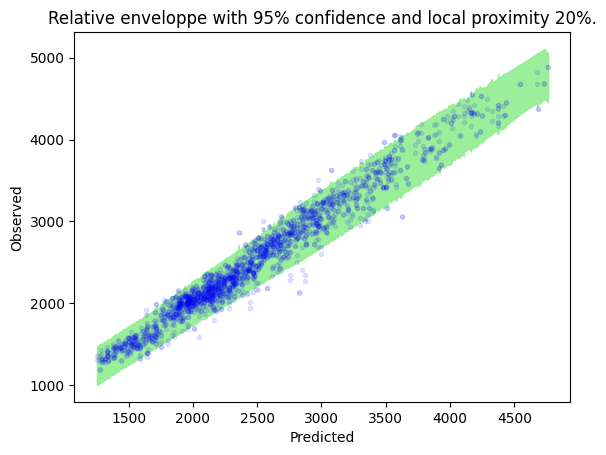

In [31]:
iqr = RelativeIqr(y,hy,p=20)
print(f"Relative Iqr score = {iqr.score():.2f}%")
iqr.plot()

- #### Model by phase

Relative Iqr score = 9.45%


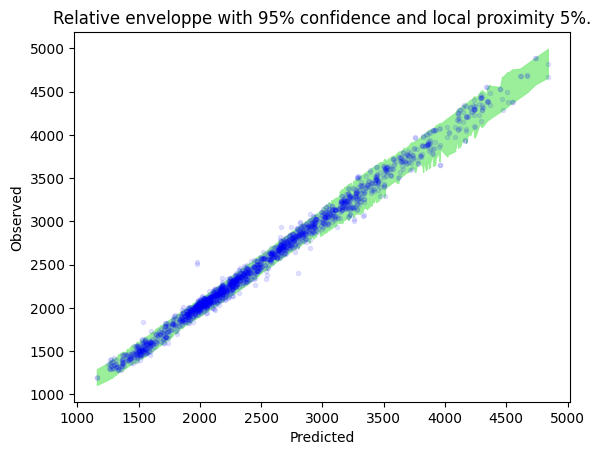

In [32]:
iqr2 = RelativeIqr(df2['Volume_L'].values, df2['Predictions'].values)
print(f"Relative Iqr score = {iqr2.score():.2f}%")
iqr2.plot()

In [33]:
MAE1 = mean_absolute_error(df1['Volume_L'], df1['Predictions'])
MAE2 = mean_absolute_error(df2['Volume_L'], df2['Predictions'])
print(f"MAE1 = {MAE1}")
print(f"MAE2 = {MAE2}")

MAE1 = 117.30145525948562
MAE2 = 51.98334015199857
